# Logistics

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!pip install geopandas
!pip install pygeos
!pip install rtree

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import scipy.stats as sp
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import MonthBegin
import seaborn as sns
import statsmodels.api as sm
from shapely.geometry import Point, LineString, Polygon
import fiona
import geopandas as gpd

# Data

In [ ]:
import geopandas as gpd

# Read the data.
#polygons = gpd.read_file('./gdrive/MyDrive/COMP0158/London_Ward.shp')
polygons = gpd.read_file('./gdrive/MyDrive/COMP0158/London_2011/London_Ward_CityMerged.shp')
#polygons = gpd.read_file('./gdrive/MyDrive/COMP0158/London_2011/London_Ward.shp')
#polygons = gpd.read_file('./gdrive/MyDrive/COMP0158/London_SHP/London_Ward.shp')
elements = pd.read_csv("./gdrive/MyDrive/COMP0158/London_Data_v6.csv")

elements = gpd.GeoDataFrame(elements,
                            geometry = gpd.points_from_xy(elements.Lon, elements.Lat),
                            crs=4326)
polygons = polygons.to_crs(4326)

polygons["Centroid"]=polygons['geometry'].centroid
polygons["dist_to_centre"] = polygons.distance(Point(-0.118092,51.509865))
polygons["log_dist_to_centre"] = np.log(polygons["dist_to_centre"])

elements = elements.to_crs(polygons.crs)

elements = gpd.sjoin(elements, polygons)
elements = elements.rename({'NAME':'Ward'}, axis='columns')

In [ ]:
def new_business_in_range(history, date1, date2):
    """ Qurey the data during specific period """
    new_busi = (history.query("(TS <= @date2 & TS >= @date1 & Version == 1) | (TS <= @date2 & TS >= @date1 & closure_tag != 'False')").reset_index(drop=True))
    return new_busi

def new_close_in_range(history, date1, date2):
    """ Qurey the data during specific period """
    new_close = (history.query("TS <= @date2 & TS >= @date1 & closure_tag != 'False'").reset_index(drop=True))
    return new_close

def updates_in_range(history, date1, date2):
    """ Qurey the data during specific period """
    update_busi = (history.query("TS <= @date2 & TS >= @date1 & Version != 1 & closure_tag == 'False'").reset_index(drop=True))
    return update_busi

def poi_in_range(history, date):
    """ Qurey the data before specific date/time """
    datedelems = (history.query("TS <= @date")
                  .groupby(['type','id'])['Version']
                  .max()
                  .reset_index())
    return pd.merge(datedelems, history, on=['type','id','Version'])

In [ ]:
pre_new, post_new = new_business_in_range(elements,"2019-04-01","2020-03-31"), new_business_in_range(elements,"2020-04-01","2021-03-31")
pre_closure, post_closure = new_close_in_range(elements,"2019-04-01","2020-03-31"), new_close_in_range(elements,"2020-04-01","2021-03-31")
pre_update, post_update = updates_in_range(elements,"2019-04-01","2020-03-31"), updates_in_range(elements,"2020-04-01","2021-03-31")
pre_poi, post_poi = gpd.GeoDataFrame(poi_in_range(elements, "2020-03-31")), gpd.GeoDataFrame(poi_in_range(elements, "2021-03-31"))

In [ ]:
# Covid Data
London_Covid = pd.read_csv("./gdrive/MyDrive/COMP0158/phe_cases_london_boroughs.csv")

# London Census Data
London_Census = pd.read_csv("./gdrive/MyDrive/COMP0158/Census by Ward.csv", encoding='latin1')

# IMD Data
IMD_Data = pd.read_excel("./gdrive/MyDrive/COMP0158/Deprivation Score/ID 2019 for London.xlsx", index_col=None,
                         sheet_name='IMD 2019')
# LSOA Mapping
LSOA_Mapping_1 = pd.read_csv("./gdrive/MyDrive/COMP0158/Deprivation Score/LSOA 2011 Mapping.csv")
LSOA_Mapping_2 = pd.read_csv("./gdrive/MyDrive/COMP0158/Deprivation Score/LSOA Mapping 2011.csv")
LSOA_Mapping = LSOA_Mapping_2.merge(LSOA_Mapping_1, how='left', left_on='OA11CD', right_on='OA11CD')

In [ ]:
xls = pd.ExcelFile('./gdrive/MyDrive/COMP0158/Deprivation Score/census-2011-oa-lookup-eng-0dd.xlsx.xlsx')
sheet_to_df_map = {}
for sheet_name in xls.sheet_names:
    sheet_to_df_map[sheet_name] = xls.parse(sheet_name)

In [ ]:
df = pd.concat(pd.read_excel('./gdrive/MyDrive/COMP0158/Deprivation Score/census-2011-oa-lookup-eng-0dd.xlsx', sheet_name=None), ignore_index=True)

In [ ]:
df.head()

,LA,OA11CD,LSOA11CD,LSOA11ANM,LAD11CD,LAD11NM,wd11cd,wd11nm
0,Barking and Dagenham,E00000037,E01000009,Barking and Dagenham 016B,E09000002,Barking and Dagenham,E05000026,Abbey
1,Barking and Dagenham,E00000038,E01000011,Barking and Dagenham 016C,E09000002,Barking and Dagenham,E05000026,Abbey
2,Barking and Dagenham,E00000039,E01000012,Barking and Dagenham 015D,E09000002,Barking and Dagenham,E05000026,Abbey
3,Barking and Dagenham,E00000040,E01000007,Barking and Dagenham 015A,E09000002,Barking and Dagenham,E05000026,Abbey
4,Barking and Dagenham,E00000041,E01000009,Barking and Dagenham 016B,E09000002,Barking and Dagenham,E05000026,Abbey


In [ ]:
# IMD Data
IMD_Data = pd.read_csv("./gdrive/MyDrive/COMP0158/Deprivation Score/Indices_of_Multiple_Deprivation_(IMD)_2019.csv", index_col=None)

IMD_Data_Mini = IMD_Data[["lsoa11cd","IMDScore"]]
IMD_Data_Mini = IMD_Data_Mini.rename({"lsoa11cd":"LSOA_CD",
                                      "IMDScore":"IMD Score"}, axis='columns')

In [ ]:
IMD_Data_Mini = IMD_Data_Mini.merge(df, how='left', left_on='LSOA_CD', right_on='LSOA11CD')
IMD_Data_Mini = pd.DataFrame(IMD_Data_Mini.groupby(['wd11cd']).mean().to_records())
IMD_Data_Mini = IMD_Data_Mini.rename({'wd11cd':"GSS_CODE"}, axis='columns')

In [ ]:
IMD_Data_Mini.to_csv("IMD_ENG.csv")

In [ ]:
IMD_Data_Mini = IMD_Data[["lsoa11cd","IMDScore"]]
IMD_Data_Mini = IMD_Data_Mini.rename({"lsoa11cd":"LSOA_CD",
                                      "IMDScore":"IMD Score"}, axis='columns')

LSOA_Mapping_Mini = LSOA_Mapping[['LSOA11CD','Ward11CD']]
LSOA_Mapping_Mini = LSOA_Mapping_Mini.rename({'LSOA11CD':"LSOA_CD",
                                              "Ward11CD":"GSS_CODE"}, axis='columns')

IMD_Data_Mini = IMD_Data_Mini.merge(LSOA_Mapping_Mini, how='left', left_on='LSOA_CD', right_on='LSOA_CD')
IMD_Data_Mini = IMD_Data_Mini.drop_duplicates()
IMD_Data_Mini.groupby(['GSS_CODE']).mean()
IMD_Data_Mini = pd.DataFrame(IMD_Data_Mini.groupby(['GSS_CODE']).mean().to_records())

In [ ]:
# London Census Data
London_Census = pd.read_csv("./gdrive/MyDrive/COMP0158/Census by Ward.csv", encoding='latin1')

# Extracting the ward names from originals
London_Census['Ward name'] = London_Census['Ward name'].apply(lambda x: x.split("-")[-1].strip())
London_Census = London_Census.drop(0)

# Renaming the desired columns
London_Census = London_Census.rename({'Ward name':'Ward',
                                      "New code":"New_Code",
                                      "Area - Square Kilometres":"Area",
                                      '% BAME - 2011':'BAME_Rate',
                                      "Population - 2015" : "Population",
                                      'Population density (persons per sq km) - 2013':"Population_Density",
                                      "Median House Price (£) - 2014":"Median_House_Price",
                                      "Mean Age - 2013":"Mean_Age",
                                      "Median Age - 2013":"Median_Age",
                                      "Employment rate (16-64) - 2011":"Employment_Rate",
                                      "Number of properties sold - 2014":"Properties_Sold",
                                      "Number of jobs in area - 2013":"Number_of_jobs_in_area",
                                      "Median Household income estimate (2012/13)":"Median_Household_income_estimate"}, axis='columns')
# Subseting the wanted 
London_Census = London_Census[['Ward',"New_Code","Area",'BAME_Rate',"Population","Population_Density","Median_House_Price",
                               "Mean_Age","Median_Age","Employment_Rate", "Properties_Sold","Number_of_jobs_in_area","Median_Household_income_estimate"]]
# Merge with IMD Data                               
London_Census = London_Census.merge(IMD_Data_Mini, how='left', left_on='New_Code', right_on='GSS_CODE')

# Log Transform Data
London_Census["log_Median_House_Price"] = np.log(London_Census["Median_House_Price"])
London_Census["log_Properties_Sold"] = np.log(London_Census["Properties_Sold"])

# Left Join with OSM Edit History
# elements = elements.merge(London_Census,how='left', left_on='Ward', right_on='Ward')

In [ ]:
London_Census.head()

,Ward,New_Code,Area,BAME_Rate,Population,Population_Density,Median_House_Price,Mean_Age,Median_Age,Employment_Rate,Properties_Sold,Number_of_jobs_in_area,Median_Household_income_estimate,GSS_CODE_x,IMD Score,log_Median_House_Price,log_Properties_Sold,GSS_CODE_y,dist_to_centre
0,Abbey,E05000026,1.3,71.9,14750.0,10500.0,173000.0,29.5,29.0,60.3,151.0,9500.0,33920.0,E05000026,31.383286,12.061047,5.017280,E05000026,0.187287
1,Alibon,E05000027,1.4,29.9,10600.0,7428.6,215000.0,33.8,33.0,63.1,119.0,1000.0,32470.0,E05000027,35.591333,12.278393,4.779123,E05000027,0.252278
2,Becontree,E05000028,1.3,41.2,12700.0,9269.2,210000.0,33.0,32.0,61.2,191.0,1300.0,33000.0,E05000028,34.999625,12.254863,5.252273,E05000028,0.228008
3,Chadwell Heath,E05000029,3.4,37.9,10400.0,2985.3,240500.0,36.2,34.0,63.6,108.0,1900.0,33920.0,E05000029,31.828833,12.390475,4.682131,E05000029,0.255455
4,Eastbrook,E05000030,3.5,24.8,10750.0,3028.6,240000.0,37.7,36.0,68.2,129.0,4000.0,37400.0,E05000030,25.605714,12.388394,4.859812,E05000030,0.277237


In [ ]:
polygons.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,Centroid,dist_to_centre,log_dist_to_centre
0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909...",POINT (-0.31203 51.34797),0.222177,-1.504282
1,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((-0.30846 51.37586, -0.30834 51.37606...",POINT (-0.28990 51.37427),0.206874,-1.575645
2,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((-0.30385 51.39249, -0.30375 51.39252...",POINT (-0.28946 51.39265),0.193197,-1.644043
3,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((-0.26990 51.38845, -0.26975 51.38838...",POINT (-0.27527 51.38389),0.193047,-1.644824
4,Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((-0.24662 51.39921, -0.24672 51.39921...",POINT (-0.25894 51.40274),0.163429,-1.811374


In [ ]:
London_Census = London_Census.merge(polygons[['GSS_CODE','dist_to_centre']], how='left', left_on='New_Code', right_on='GSS_CODE')

In [ ]:
London_Census.to_csv("London_Census.csv",index=False)

In [ ]:
import fiona
fiona.supported_drivers
elements = gpd.GeoDataFrame(pd.read_csv("./gdrive/MyDrive/COMP0158/London_Data_v6.csv"))
elements = gpd.GeoDataFrame(elements,
                            geometry = gpd.points_from_xy(elements.Lon, elements.Lat),
                            crs=4326)
elements.to_file("London_History.shp")

# Linear Regression

In [ ]:
London_Census.to_csv("London_Census.csv",index=False)

In [ ]:
# To summarize information from dataframe in order to perform regression
def df_summary(df1,df2,df3):
    """
    df1 := creation/deletion/update historical records
    df2 := Other Information to include (Independent Variables)
    df3 := historical records of editions
    """
    # Formatting Time Stamp of each record into a monthly manner
    df1['TS'] = pd.to_datetime(pd.to_datetime(df1['TS']).dt.date)
    df1['TS'] = df1['TS'].apply(lambda x: x + MonthEnd(0) - MonthBegin(1))

    # Create Pivot table of Monthly total cases
    pivot_1 = df1.pivot_table(values='id', index='TS', columns='GSS_CODE', aggfunc=pd.Series.nunique)
    pivot_agg = pd.DataFrame(pivot_1.to_records())
    pivot_agg = pivot_agg.drop(["TS"],axis=1)
    pivot_agg = pivot_agg.sum().to_frame().reset_index()
    pivot_agg = pivot_agg.rename({"index":"GSS_CODE",0:"Metric"},axis='columns')
    
    # Count total # of POIs within areas
    poi_agg = df3.pivot_table(values='id', columns='GSS_CODE', aggfunc=pd.Series.nunique)
    poi_agg  = pd.DataFrame(poi_agg.to_records())
    poi_agg = poi_agg.drop(["index"],axis=1).T.reset_index()
    poi_agg = poi_agg.rename({"index":"GSS_CODE",0:"Total_POI"},axis='columns')

    # Merge other information at a spatial unit level
    new_data = df2.merge(pivot_agg, how='left', left_on='New_Code', right_on='GSS_CODE')
    new_data = new_data.merge(poi_agg, how='left', left_on='New_Code', right_on='GSS_CODE')

    # Normalization by area size
    new_data["Metric_Ratio"] = new_data["Metric"]/new_data["Area"]
    new_data["log_Metric"] = np.log(new_data["Metric"]/new_data["Area"])
    new_data = new_data.drop(["GSS_CODE_x","GSS_CODE_y"],axis=1)

    return new_data

# Merging information with Polygons Dataframe
def Merge_with_Polygons(polygons, df):
    new_polygons = polygons.merge(df, how='left', left_on='GSS_CODE', right_on='New_Code')
    new_polygons['log_Metric'] = new_polygons['log_Metric'].fillna(np.log(0.05))
    return new_polygons


In [ ]:
# Opening
pre_new_data = df_summary(pre_new,London_Census,pre_poi)
post_new_data = df_summary(post_new,London_Census,post_poi)
pre_new_polygons = Merge_with_Polygons(polygons, pre_new_data)
post_new_polygons = Merge_with_Polygons(polygons, post_new_data)

# Closure
pre_closure_data = df_summary(pre_closure,London_Census,pre_poi)
post_closure_data = df_summary(post_closure,London_Census,post_poi)
pre_closure_polygons = Merge_with_Polygons(polygons, pre_closure_data)
post_closure_polygons = Merge_with_Polygons(polygons, post_closure_data)

# Update
pre_update_data = df_summary(pre_update,London_Census,pre_poi)
post_update_data = df_summary(post_update,London_Census,post_poi)
pre_update_polygons = Merge_with_Polygons(polygons, pre_update_data)
post_update_polygons = Merge_with_Polygons(polygons, post_update_data)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2, figsize=(20, 7.5), sharey='row')

#new_polygons.plot(column='Sustenance', ax=ax, legend=True)

new_polygons1 = Merge_with_Polygons(polygons, pre_new_data)

new_polygons2 = Merge_with_Polygons(polygons, post_new_data)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
new_polygons1.plot(column='log_Metric', ax=ax[0], legend=True, cax=cax)
plt.setp(ax[0], xlabel='Pre-Pandemic')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
new_polygons2.plot(column='log_Metric', ax=ax[1], legend=True, cax=cax)
plt.setp(ax[1], xlabel='Post-Pandemic')

plt.suptitle("Log New Business Opening Rate (Number of New POIs/Area Size)",fontsize=20)

plt.savefig("New_Opening_Heatmap.jpg",bbox_inches = 'tight')

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2, figsize=(20, 7.5), sharey='row')

#new_polygons.plot(column='Sustenance', ax=ax, legend=True)

new_polygons1 = Merge_with_Polygons(polygons, pre_new_data)

new_polygons2 = Merge_with_Polygons(polygons, post_new_data)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
new_polygons1.plot(column='dist_to_centre', ax=ax[0], legend=True, cax=cax)
plt.setp(ax[0], xlabel='Pre-Pandemic')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
new_polygons2.plot(column='IMD Score', ax=ax[1], legend=True, cax=cax)
plt.setp(ax[1], xlabel='Post-Pandemic')

plt.suptitle("Log New Business Opening Rate (Number of New POIs/Area Size)",fontsize=20)

plt.savefig("New_Opening_Heatmap.jpg",bbox_inches = 'tight')

## Linear Model

In [ ]:
import seaborn as sns
import statsmodels.api as sm
from shapely.geometry import Point, LineString, Polygon

### Normality Check

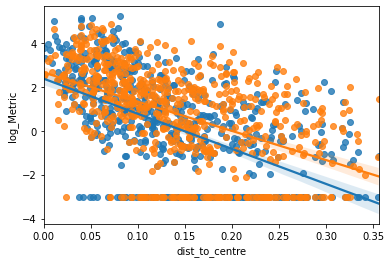

In [ ]:
sns.regplot(data=pre_new_polygons, x="dist_to_centre", y="log_Metric")
sns.regplot(data=post_new_polygons, x="dist_to_centre", y="log_Metric")

In [ ]:
import seaborn as sns

# List of five airlines to plot
airlines = ['United Air Lines Inc.', 'JetBlue Airways', 'ExpressJet Airlines Inc.'',
         'Delta Air Lines Inc.', 'American Airlines Inc.']

# Iterate through the five airlines
for airline in airlines:
    # Subset to the airline
    subset = flights[flights['name'] == airline]
    
    # Draw the density plot
    sns.distplot(subset['arr_delay'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = airline)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Airline')
plt.title('Density Plot with Multiple Airlines')
plt.xlabel('Delay (min)')
plt.ylabel('Density')

In [ ]:
# List of variables to plot
var_list = ['BAME_Rate',
 'Population',
 'Population_Density',
 'Median_House_Price',
 'Mean_Age',
 'Median_Age',
 'Employment_Rate',
 'Properties_Sold',
 'IMD Score']

for var in var_list:
    #sns.displot(data=London_Census, x= var, kind="kde", label = var)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.kdeplot(np.log(London_Census[var]), shade=True, ax=ax[1])
    sns.kdeplot(London_Census[var], shade=True, ax=ax[0])
    plt.show()


#sns.displot(data=London_Census, x="BAME_Rate", kind="kde")


In [ ]:
var_list = ["dist_to_centre"]
X = pre_new_polygons[var_list]

Y = pre_new_polygons["log_Metric"]
X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X,missing='drop').fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             log_Metric   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     259.5
Date:                Thu, 22 Jul 2021   Prob (F-statistic):           4.66e-49
Time:                        13:34:56   Log-Likelihood:                -1304.8
No. Observations:                 625   AIC:                             2614.
Df Residuals:                     623   BIC:                             2623.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.3663      0.159     14.

In [ ]:
var_list = ["Population_Density", 
            "IMD Score",
            'BAME_Rate',
            'log_Median_House_Price',
            'log_Properties_Sold',
            'Mean_Age',
            'Employment_Rate'
            ]

X = post_new_polygons[var_list]

Y = post_new_polygons["log_Metric"]
X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X,missing='drop').fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             log_Metric   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     202.9
Date:                Thu, 22 Jul 2021   Prob (F-statistic):           4.67e-40
Time:                        13:34:49   Log-Likelihood:                -1266.7
No. Observations:                 625   AIC:                             2537.
Df Residuals:                     623   BIC:                             2546.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.6481      0.150     17.

In [ ]:
X = pre_update_polygons[["Population_Density", 
                     "IMD Score",
                     'BAME_Rate',
                     'log_Median_House_Price',
                     'log_Properties_Sold',
                     'Mean_Age',
                     'Employment_Rate']]

Y = pre_update_polygons["log_Metric"]
X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X,missing='drop').fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             log_Metric   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     79.20
Date:                Mon, 19 Jul 2021   Prob (F-statistic):           1.02e-81
Time:                        17:26:18   Log-Likelihood:                -1190.7
No. Observations:                 625   AIC:                             2397.
Df Residuals:                     617   BIC:                             2433.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -32

In [ ]:
X = pre_update_polygons[["Population_Density", 
                     "IMD Score",
                     'BAME_Rate',
                     'log_Median_House_Price',
                     'log_Properties_Sold',
                     'Mean_Age',
                     'Employment_Rate'
                     ]]

Y = post_update_polygons["log_Metric"]
X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X,missing='drop').fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             log_Metric   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     100.5
Date:                Mon, 19 Jul 2021   Prob (F-statistic):           1.18e-97
Time:                        17:26:50   Log-Likelihood:                -1079.5
No. Observations:                 625   AIC:                             2175.
Df Residuals:                     617   BIC:                             2211.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -32

# Time Series Analysis

In [ ]:
past_new, past_closure, past_update, past_poi = (new_business_in_range(elements,"2018-04-01","2019-03-31"), 
                                                 new_close_in_range(elements,"2018-04-01","2019-03-31"),
                                                 updates_in_range(elements,"2018-04-01","2019-03-31"),
                                                 gpd.GeoDataFrame(poi_in_range(elements, "2019-03-31")))

In [ ]:
# Opening
past_new_data = df_summary(past_new,London_Census,past_poi)
past_new_polygons = Merge_with_Polygons(polygons, past_new_data)

# Closure
past_closure_data = df_summary(past_closure,London_Census,past_poi)
past_closure_polygons = Merge_with_Polygons(polygons, past_closure_data)

# Update
past_update_data = df_summary(past_update,London_Census,past_poi)
past_update_polygons = Merge_with_Polygons(polygons, past_update_data)

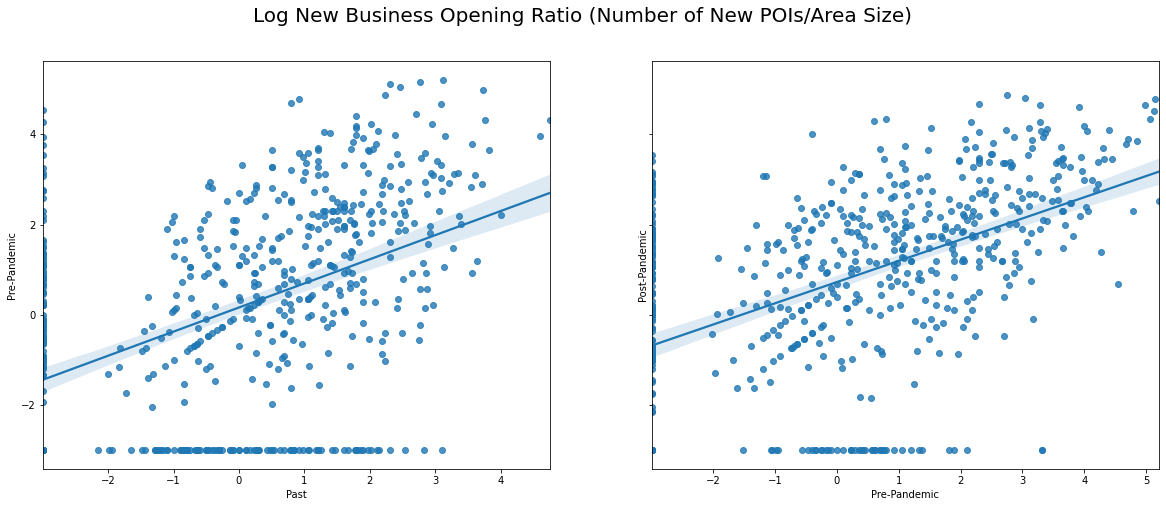

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7.5), sharey='row')
sns.regplot(x=past_new_polygons['log_Metric'],y=pre_new_polygons['log_Metric'], ax=ax[0])
ax[0].set(xlabel='Past', ylabel='Pre-Pandemic')
sns.regplot(x=pre_new_polygons['log_Metric'],y=post_new_polygons['log_Metric'], ax=ax[1])
ax[1].set(xlabel='Pre-Pandemic', ylabel='Post-Pandemic')

plt.suptitle("Log New Business Opening Ratio (Number of New POIs/Area Size)",fontsize=20)
plt.savefig("New_Time.jpg")

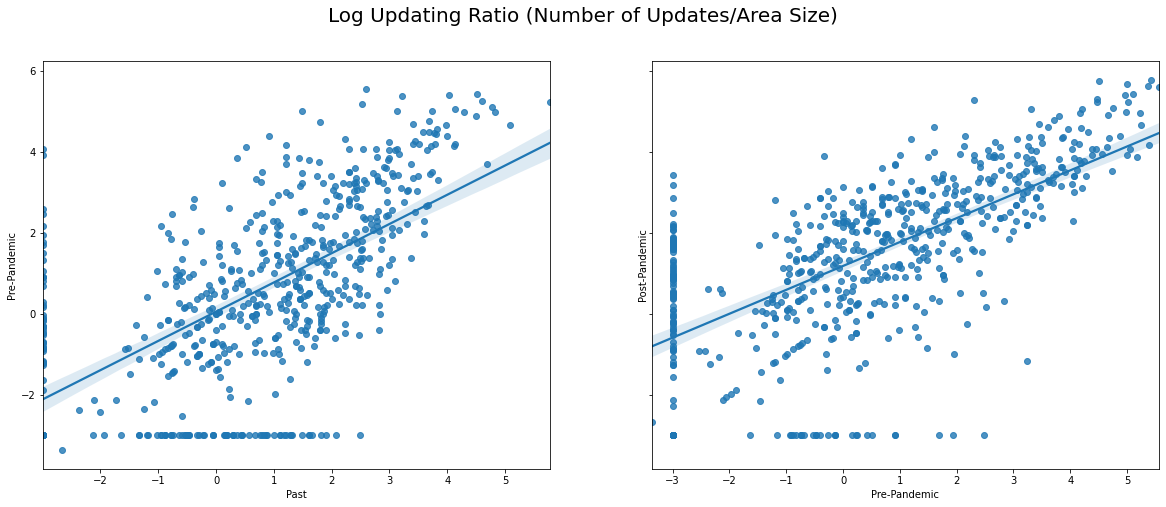

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7.5), sharey='row')
sns.regplot(x=past_update_polygons['log_Metric'],y=pre_update_polygons['log_Metric'], ax=ax[0])
ax[0].set(xlabel='Past', ylabel='Pre-Pandemic')
sns.regplot(x=pre_update_polygons['log_Metric'],y=post_update_polygons['log_Metric'], ax=ax[1])
ax[1].set(xlabel='Pre-Pandemic', ylabel='Post-Pandemic')
plt.suptitle("Log Updating Ratio (Number of Updates/Area Size)",fontsize=20)
plt.savefig("Updating_Time.jpg")

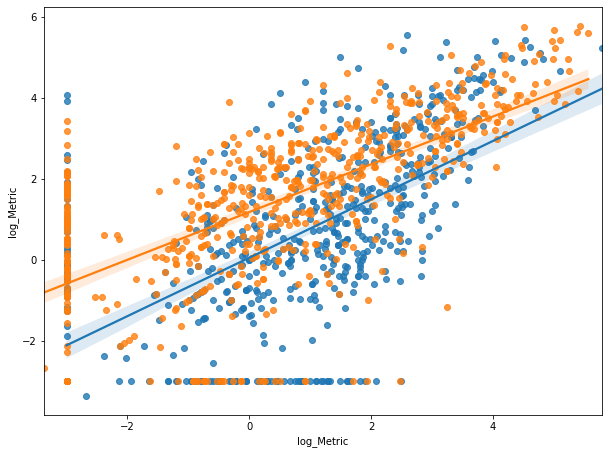

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7.5))
sns.regplot(x=past_update_polygons['log_Metric'],y=pre_update_polygons['log_Metric'])
sns.regplot(x=pre_update_polygons['log_Metric'],y=post_update_polygons['log_Metric'])
#plt.suptitle("Log Updating Ratio (Number of Updates/Area Size)",fontsize=20)
#plt.savefig("Updating_Time.jpg")

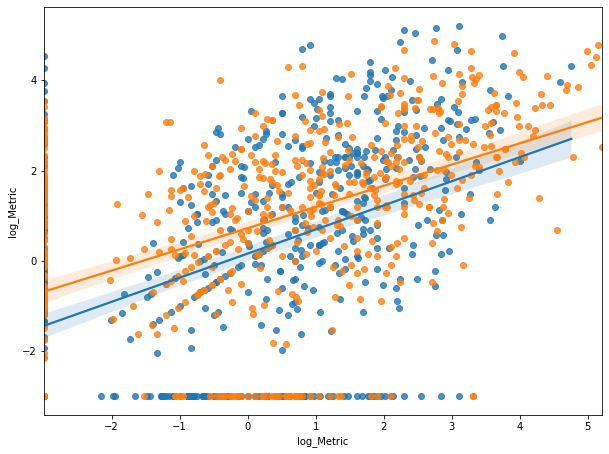

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7.5))
sns.regplot(x=past_new_polygons['log_Metric'],y=pre_new_polygons['log_Metric'])
sns.regplot(x=pre_new_polygons['log_Metric'],y=post_new_polygons['log_Metric'])